# Initialize

## Import all libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.metrics import silhouette_samples, silhouette_score

In [ ]:
# import all data Movielens 100K
df_movies = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/movies.csv")
df_ratings = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/ratings.csv")
df_tags = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/tags.csv")
df_links = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/links.csv")

# df_genome_scores = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/genome-scores.csv")
# df_genome_tags = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/genome-tags.csv")
# df_links = pd.read_csv("/content/drive/MyDrive/MovieLensRecommendationEngine/data/links.csv")

## Let's look at the data

In [ ]:
print(len(df_movies))
df_movies.head(1)


9742


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
print(len(df_ratings))
df_ratings.head(1)

100836


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703


In [ ]:
print(len(df_tags))
df_tags.head(1)

3683


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994


In [ ]:
print(len(df_links))
df_links.head(1)

9742


,movieId,imdbId,tmdbId
0,1,114709,862.0


# Data Cleaning

## Few movies are missing year of release, let's add that

In [ ]:
df_movies.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
add_year = {'Babylon 5':1994, 'Ready Player One':2018,'Hyena Road':2016,'The Adventures of Sherlock Holmes and Doctor Watson':1980,'Nocturnal Animals':2016,'Paterson':2016,'Moonlight':2016,'The OA':2016,'Maria Bamford: Old Baby':2017,'Generation Iron 2':2017,'Black Mirror':2011}

In [ ]:
for index,movie in df_movies.iterrows():
  if '(' not in movie['title']:
    if movie['title'] in add_year:
      moviename = movie['title']+' ('+str(add_year[movie['title']])+')'
      df_movies.loc[index,'title'] = str(moviename)

    else:
      # remove the movie from db
      print('Dropped ',movie['title'])
      df_movies = df_movies.drop(index)
    

Dropped  Cosmos


In [ ]:
# Add year column separately from the title
# If this works without error, then there aren't any movies with no release year
temp = df_movies.copy()
temp['year'] = temp['title'].apply(lambda x: str(x).split('(')[1].split(')')[0])

In [ ]:
temp.head()

,movieId,title,genres,year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II (1995),Comedy,1995


##  Genres - Not being used, but useful

In [ ]:
df_movies.head(1)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy


In [ ]:
genre_list = ['Action','Adventure','Animation','Children\'s','Comedy','Crime','Documentary','Drama','Fantasy','Film-Noir','Horror','Musical','Mystery','Romance','Sci-Fi','Thriller','War','Western','(no genres listed)']

In [ ]:

for genre in genre_list:
  mov = df_movies[df_movies['genres'].str.contains(genre)]
  print(mov)
  rate = df_ratings[df_ratings['movieId'].isin(mov['movieId'])]
  print(rate)
  break

      movieId  ...                              genres
5           6  ...               Action|Crime|Thriller
8           9  ...                              Action
9          10  ...           Action|Adventure|Thriller
14         15  ...            Action|Adventure|Romance
19         20  ...  Action|Comedy|Crime|Drama|Thriller
...       ...  ...                                 ...
9722   189547  ...                       Action|Sci-Fi
9731   191005  ...      Action|Adventure|Comedy|Sci-Fi
9732   193565  ...      Action|Animation|Comedy|Sci-Fi
9737   193581  ...     Action|Animation|Comedy|Fantasy
9740   193587  ...                    Action|Animation

[1828 rows x 3 columns]
        userId  movieId  rating   timestamp
2            1        6     4.0   964982224
5            1       70     3.0   964982400
7            1      110     4.0   964982176
8            1      151     5.0   964984041
10           1      163     5.0   964983650
...        ...      ...     ...         ...
100826 

# Clustering - K-means

## Let's create the dataset

In [ ]:
ratings = pd.merge(df_ratings, df_movies[['movieId', 'title']], on='movieId' )
ratings.head()

,userId,movieId,rating,timestamp,title
0,1,1,4.0,964982703,Toy Story (1995)
1,5,1,4.0,847434962,Toy Story (1995)
2,7,1,4.5,1106635946,Toy Story (1995)
3,15,1,2.5,1510577970,Toy Story (1995)
4,17,1,4.5,1305696483,Toy Story (1995)


In [ ]:
# Pivot
user_movies = pd.pivot_table(ratings, index='userId', columns= 'title', values='rating')
print('Dimensions',user_movies.shape)

Dimensions (610, 9718)


In [ ]:
user_movies.head(2)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## The dataset is sparse
- Very few values are there
- Sort by most rated movies and users who have rated the most number of movies - dense region on top
- We will use top 5000 movies for now, then increase to the total dataset

In [ ]:
#let's sort this based on the most rated movies first
num_movies = 1000
user_movie_rated = user_movies.append(user_movies.count(), ignore_index=True)
# user_movies['count'] = pd.Series(user_movies.count(axis=1))

In [ ]:
user_movie_rated.tail(1)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
610,1.0,1.0,2.0,1.0,2.0,1.0,17.0,1.0,42.0,7.0,1.0,3.0,1.0,1.0,4.0,2.0,14.0,3.0,54.0,1.0,17.0,4.0,1.0,47.0,44.0,1.0,1.0,9.0,1.0,2.0,1.0,2.0,4.0,1.0,57.0,1.0,1.0,1.0,3.0,16.0,...,4.0,1.0,1.0,2.0,2.0,1.0,1.0,2.0,1.0,7.0,14.0,15.0,3.0,1.0,1.0,1.0,38.0,2.0,2.0,1.0,53.0,1.0,2.0,4.0,54.0,3.0,1.0,1.0,32.0,4.0,1.0,8.0,3.0,2.0,1.0,22.0,24.0,5.0,26.0,1.0


In [ ]:
user_movie_ratings_sorted = user_movie_rated.sort_values(len(user_movie_rated)-1, axis=1, ascending=False)
user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)

In [ ]:
# slice the count
most_rated_movies = user_movie_ratings_sorted.iloc[:, :num_movies]

In [ ]:
print(len(most_rated_movies))
most_rated_movies.tail()

610


title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),American Beauty (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),"Lord of the Rings: The Two Towers, The (2002)",Saving Private Ryan (1998),"Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),Mission: Impossible (1996),...,Guardians of the Galaxy 2 (2017),Ghost in the Shell (Kôkaku kidôtai) (1995),"People vs. Larry Flynt, The (1996)",Bedazzled (2000),"Island of Dr. Moreau, The (1996)",Gosford Park (2001),"Princess Diaries, The (2001)",Rise of the Planet of the Apes (2011),Wayne's World 2 (1993),Evolution (2001),Star Trek Into Darkness (2013),All the President's Men (1976),Forever Young (1992),Pride & Prejudice (2005),Cube (1997),Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Arrival (2016),National Lampoon's Vacation (1983),Waking Ned Devine (a.k.a. Waking Ned) (1998),"Village, The (2004)","Virgin Suicides, The (1999)",Harold and Maude (1971),"Mighty Ducks, The (1992)",Dick Tracy (1990),Airheads (1994),¡Three Amigos! (1986),Roman Holiday (1953),Private Parts (1997),About Schmidt (2002),Jacob's Ladder (1990),"Transporter, The (2002)",The Hunger Games: Catching Fire (2013),21 Jump Street (2012),Moonraker (1979),In & Out (1997),Muppet Treasure Island (1996),Moneyball (2011),Rocky II (1979),"Big Short, The (2015)",Spawn (1997)
605,4.0,3.5,5.0,4.5,5.0,4.5,2.5,3.5,3.5,5.0,5.0,2.5,4.5,4.5,4.5,3.0,2.5,NaN,3.5,4.5,4.5,4.0,NaN,3.5,4.5,4.0,4.5,NaN,NaN,4.0,NaN,4.0,NaN,3.5,NaN,4.0,3.5,2.5,4.0,2.5,...,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.5,NaN,3.5,4.0,NaN,NaN,NaN,4.0,NaN,4.0,3.5,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,2.5,NaN,NaN
606,NaN,5.0,3.0,5.0,5.0,3.0,4.0,5.0,4.0,5.0,NaN,4.0,3.0,3.0,NaN,NaN,4.0,5.0,NaN,NaN,3.0,4.0,5.0,3.0,NaN,5.0,NaN,NaN,2.0,5.0,4.0,NaN,NaN,3.0,5.0,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
607,3.0,4.5,5.0,4.0,5.0,3.5,3.0,4.0,3.0,4.0,5.0,2.5,4.0,5.0,4.5,4.5,3.0,2.0,NaN,4.5,4.0,5.0,3.0,3.0,4.5,4.5,4.0,3.0,3.0,4.5,3.0,3.5,3.5,2.0,2.5,4.5,4.0,3.5,3.0,3.5,...,NaN,3.5,NaN,3.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,NaN,3.5,NaN,NaN,1.0,3.5,NaN,NaN,NaN,2.5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,3.0
608,4.0,4.0,4.0,NaN,NaN,NaN,3.0,3.0,3.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
609,3.0,3.0,5.0,4.5,5.0,5.0,5.0,4.5,5.0,3.5,5.0,5.0,5.0,3.5,4.0,5.0,3.5,NaN,5.0,5.0,5.0,5.0,4.5,4.5,5.0,5.0,5.0,NaN,4.5,4.5,5.0,4.5,NaN,5.0,5.0,3.5,5.0,NaN,NaN,NaN,...,NaN,4.5,NaN,2.5,NaN,NaN,NaN,4.0,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN


In [ ]:
#  all_user_movies = user_movies.sort_values('count', ascending=False)

In [ ]:
# most_rated_user_movies = all_user_movies.iloc[:num_movies, :]
# most_rated_user_movies = most_rated_user_movies.drop(['count'], axis=1)

In [ ]:
# most_rated_user_movies.head(5)

## Let's create the CSR matrix

In [ ]:
sdf = most_rated_movies.astype(pd.SparseDtype("float", np.nan))

In [ ]:
sdf.sparse.density

0.10041967213114754

In [ ]:
sdf.sparse.to_coo()

<610x1000 sparse matrix of type '<class 'numpy.float64'>'
	with 61256 stored elements in COOrdinate format>

In [ ]:
# Let's check it back
sparse_ratings = csr_matrix(sdf.sparse.to_coo())

In [ ]:
check = pd.DataFrame.sparse.from_spmatrix(sparse_ratings)
check.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,960,961,962,963,964,965,966,967,968,969,970,971,972,973,974,975,976,977,978,979,980,981,982,983,984,985,986,987,988,989,990,991,992,993,994,995,996,997,998,999
0,4.0,0.0,3.0,4.0,5.0,5.0,4.0,4.0,0.0,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,0.0,5.0,0.0,5.0,0.0,5.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,5.0,3.0,4.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,5.0,1.0,5.0,0.0,0.0,0.0,0.0,2.0,0.0,5.0,5.0,0.0,2.0,0.0,0.0,3.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,4.0,5.0,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,3.0,5.0,0.0,0.0,0.0,0.0,4.0,3.0,5.0,0.0,4.0,0.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,4.0,3.0,0.0,0.0,0.0,4.0,3.0,0.0,2.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Visualize

# Optimal K - Run only once - Current K selected = 6
- Silhoutte method


In [ ]:
possible_k_values = range(2, 25, 1)
k_val = [a for a in possible_k_values]
sil_avg = []
samp_sil_val = []
print(k_val)

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


In [ ]:
for n_clusters in possible_k_values:
  clusterer = KMeans(n_clusters=n_clusters,algorithm='full')
  cluster_labels = clusterer.fit_predict(sparse_ratings)
  silhouette_avg = silhouette_score(sparse_ratings, cluster_labels)
  sil_avg.append(silhouette_avg)
  sample_silhouette_values = silhouette_samples(sparse_ratings,cluster_labels)
  samp_sil_val.append(sample_silhouette_values)
  print('For cluster {}, the average silhouette score is {}'.format(n_clusters, silhouette_avg))

For cluster 2, the average silhouette score is 0.3520453847797507
For cluster 3, the average silhouette score is 0.23854953492965442
For cluster 4, the average silhouette score is 0.2327779993805496
For cluster 5, the average silhouette score is 0.030872629120294762
For cluster 6, the average silhouette score is 0.03534911239864286
For cluster 7, the average silhouette score is 0.029303095284243887
For cluster 8, the average silhouette score is 0.03536448019553169
For cluster 9, the average silhouette score is 0.023631051158504553
For cluster 10, the average silhouette score is 0.030519107051304638
For cluster 11, the average silhouette score is 0.03928478908486416
For cluster 12, the average silhouette score is -0.0003171336571970671
For cluster 13, the average silhouette score is -0.0006977385780733377
For cluster 14, the average silhouette score is 0.024151337056236982
For cluster 15, the average silhouette score is -0.011163812676756845
For cluster 16, the average silhouette score 

In [ ]:
print(sil_avg)
print(k_val)

[0.3520453847797507, 0.23854953492965442, 0.2327779993805496, 0.030872629120294762, 0.03534911239864286, 0.029303095284243887, 0.03536448019553169, 0.023631051158504553, 0.030519107051304638, 0.03928478908486416, -0.0003171336571970671, -0.0006977385780733377, 0.024151337056236982, -0.011163812676756845, 0.02594252427508804, -0.010496908618813802, -0.006064788512503177, -0.0034974681108597473, -0.024121733328441145, -0.010450803520953891, -0.006258606511634582, -0.010340721698097511, 0.032677350709084826]
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24]


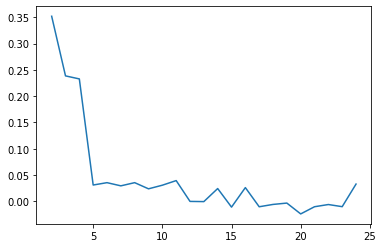

In [ ]:
plt.plot(k_val, sil_avg)
# So, we will select 6 clusters

# Previous values - Hide

- For cluster 5, the average silhouette score is -0.007949007135515532
- For cluster 10, the average silhouette score is -0.007319061829631084
- For cluster 15, the average silhouette score is 0.06596843169848818
- For cluster 20, the average silhouette score is -0.0024835502092100813
- For cluster 25, the average silhouette score is 0.00025261324755294673
- For cluster 30, the average silhouette score is -0.12377465329012385
- For cluster 35, the average silhouette score is 0.0014136607876502078
- For cluster 40, the average silhouette score is -0.005981263657415396
- For cluster 45, the average silhouette score is -0.07360037732190812
- For cluster 50, the average silhouette score is -0.05782397788418093
- For cluster 55, the average silhouette score is -0.01600257577134178
- For cluster 60, the average silhouette score is -0.051782711838991934
- For cluster 65, the average silhouette score is 0.0025508372858048687
- For cluster 70, the average silhouette score is -0.011208975638347142
- For cluster 75, the average silhouette score is -0.034637484845428376
- For cluster 80, the average silhouette score is -0.005327163404530266
- For cluster 85, the average silhouette score is -0.025301259018795097
- For cluster 90, the average silhouette score is 0.014095549716863559
- For cluster 95, the average silhouette score is -0.02436565607848807
- For cluster 100, the average silhouette score is -0.02935330031976765
- For cluster 105, the average silhouette score is -0.012487055216700507
- For cluster 110, the average silhouette score is -0.03655599363132131
- For cluster 115, the average silhouette score is -0.0011293262147994228
- For cluster 120, the average silhouette score is -0.02473405994612815
- For cluster 125, the average silhouette score is -0.0892131623590398
- For cluster 130, the average silhouette score is -0.00044310630183416755
- For cluster 135, the average silhouette score is 0.0001835752194179131
- For cluster 140, the average silhouette score is -0.025734967286221346


Let's choose K=90

In [ ]:
# possible_k_values = range(100, 14, 5)
# for n_clusters in possible_k_values:
#   clusterer = KMeans(n_clusters=n_clusters,algorithm='full')
#   cluster_labels = clusterer.fit_predict(sparse_ratings)
#   silhouette_avg = silhouette_score(sparse_ratings, cluster_labels)
#   sample_silhouette_values = silhouette_samples(sparse_ratings,cluster_labels)
#   print('For cluster {}, the average silhouette score is {}'.format(n_clusters, silhouette_avg))

For cluster 100, the average silhouette score is -0.02935330031976765
For cluster 105, the average silhouette score is -0.012487055216700507
For cluster 110, the average silhouette score is -0.03655599363132131
For cluster 115, the average silhouette score is -0.0011293262147994228
For cluster 120, the average silhouette score is -0.02473405994612815
For cluster 125, the average silhouette score is -0.0892131623590398
For cluster 130, the average silhouette score is -0.00044310630183416755
For cluster 135, the average silhouette score is 0.0001835752194179131
For cluster 140, the average silhouette score is -0.025734967286221346


In [ ]:

possible_k_values = [10, 15, 25, 35, 65, 90, 135]
for n_clusters in possible_k_values:
  clusterer = KMeans(n_clusters=n_clusters,algorithm='full')
  cluster_labels = clusterer.fit_predict(sparse_ratings)
  silhouette_avg = silhouette_score(sparse_ratings, cluster_labels)
  sample_silhouette_values = silhouette_samples(sparse_ratings,cluster_labels)
  print('For cluster {}, the average silhouette score is {}'.format(n_clusters, silhouette_avg))

For cluster 10, the average silhouette score is -0.006861280357817774
For cluster 15, the average silhouette score is -0.00722894406236808
For cluster 25, the average silhouette score is -0.0003530486020109342
For cluster 35, the average silhouette score is 0.006506467175390686


In [ ]:
import matplotlib.cm as cm

In [ ]:
for n_clusters in range_n_clusters:
    fig=plt.figure()
    # Subplot with 1 row and 2 columns
#     fig,(ax1,ax2) = plt.subplot(1,2,1)
    ax1 = plt.subplot(1,2,1)
    fig.set_size_inches(10,5)
    
    # 1st plot is the silhouette plot - x: score, y: no. of clusters
    # x-axis range - (-1,1)
    # but we saw in all values, the score is between (-0.1,1)
    ax1.set_xlim([-0.1,1])
    # y axis let's see the blackspace as well
    ax1.set_ylim([0,len(X)+(n_clusters+1*10)])
    
    
    # Initilize clusterer with random generator seed of 10 for reproducibility
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    # Score gives the average value for all the samples
    # Gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
                  
    # Compute for each sample
    sample_silhouette_values = silhouette_samples(X,cluster_labels)
    
    print('For cluster {}, the average silhouette score is {}'.format(n_clusters, silhouette_avg))
                  
    y_lower = 10
    for i in range(n_clusters):
        ith_cluster_score = sample_silhouette_values[cluster_labels == i]
        ith_cluster_score.sort()
        
        size_cluster_i = ith_cluster_score.shape[0]
        
        y_upper = y_lower + size_cluster_i
        color = cm.nipy_spectral(float(i)/n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper),0,ith_cluster_score, facecolor=color, edgecolor=color,alpha=0.7)
        ax1.text(-0.05, y_lower+0.5*size_cluster_i,str(i))
        
        y_lower = y_upper+10 
    ax1.set_title('The silhouette point for various clusters')
    ax1.set_xlabel('The silhouette coefficient values')
    ax1.set_ylabel('Cluster label')
    
    ax1.axvline(x=silhouette_avg,color='red',linestyle='-')
    
    ax1.set_yticks([])
    ax1.set_xticks([-0.1,0,0.2,0.4,0.6,0.8,1])
    
    ax2 = plt.subplot(1,2,2)
    colors = cm.nipy_spectral(cluster_labels.astype(float)/n_clusters)
    ax2.scatter(X[:,0],X[:,1],s=30,marker='.',c=colors,lw=0,alpha=0.7, edgecolor='k')
    
    centers = clusterer.cluster_centers_
    ax2.scatter(centers[:,0],centers[:,1], marker='o',c='white',alpha=1, s=200, edgecolor='k')
    
    ax2.set_title('The visualization of the clustered data')
    ax2.set_xlabel('Feature space for the 1st feature')
    ax2.set_ylabel('Feature space for the 2nd feature')
    
#     fig.set_title('Silhouette analysis')

# Clustering

In [ ]:
predictions = KMeans(n_clusters=10, algorithm='full').fit_predict(sparse_ratings)

In [ ]:
most_rated_movies.head(1)

title,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),American Beauty (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),"Lord of the Rings: The Two Towers, The (2002)",Saving Private Ryan (1998),"Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),Mission: Impossible (1996),...,Guardians of the Galaxy 2 (2017),Ghost in the Shell (Kôkaku kidôtai) (1995),"People vs. Larry Flynt, The (1996)",Bedazzled (2000),"Island of Dr. Moreau, The (1996)",Gosford Park (2001),"Princess Diaries, The (2001)",Rise of the Planet of the Apes (2011),Wayne's World 2 (1993),Evolution (2001),Star Trek Into Darkness (2013),All the President's Men (1976),Forever Young (1992),Pride & Prejudice (2005),Cube (1997),Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Arrival (2016),National Lampoon's Vacation (1983),Waking Ned Devine (a.k.a. Waking Ned) (1998),"Village, The (2004)","Virgin Suicides, The (1999)",Harold and Maude (1971),"Mighty Ducks, The (1992)",Dick Tracy (1990),Airheads (1994),¡Three Amigos! (1986),Roman Holiday (1953),Private Parts (1997),About Schmidt (2002),Jacob's Ladder (1990),"Transporter, The (2002)",The Hunger Games: Catching Fire (2013),21 Jump Street (2012),Moonraker (1979),In & Out (1997),Muppet Treasure Island (1996),Moneyball (2011),Rocky II (1979),"Big Short, The (2015)",Spawn (1997)
0,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,NaN,5.0,NaN,5.0,NaN,5.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,3.0,4.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
max_users = 70
max_movies = 50

clustered = pd.concat([most_rated_movies.reset_index(), pd.DataFrame({'group':predictions})], axis=1)

In [ ]:
print(clustered['group'].unique())
print(clustered['group'].value_counts())
clustered.head()

[2 3 6 0 7 8 9 4 1 5]
3    278
7     97
6     79
2     50
4     32
8     24
0     22
9     12
1      9
5      7
Name: group, dtype: int64


,index,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),American Beauty (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),"Lord of the Rings: The Two Towers, The (2002)",Saving Private Ryan (1998),"Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),...,Ghost in the Shell (Kôkaku kidôtai) (1995),"People vs. Larry Flynt, The (1996)",Bedazzled (2000),"Island of Dr. Moreau, The (1996)",Gosford Park (2001),"Princess Diaries, The (2001)",Rise of the Planet of the Apes (2011),Wayne's World 2 (1993),Evolution (2001),Star Trek Into Darkness (2013),All the President's Men (1976),Forever Young (1992),Pride & Prejudice (2005),Cube (1997),Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Arrival (2016),National Lampoon's Vacation (1983),Waking Ned Devine (a.k.a. Waking Ned) (1998),"Village, The (2004)","Virgin Suicides, The (1999)",Harold and Maude (1971),"Mighty Ducks, The (1992)",Dick Tracy (1990),Airheads (1994),¡Three Amigos! (1986),Roman Holiday (1953),Private Parts (1997),About Schmidt (2002),Jacob's Ladder (1990),"Transporter, The (2002)",The Hunger Games: Catching Fire (2013),21 Jump Street (2012),Moonraker (1979),In & Out (1997),Muppet Treasure Island (1996),Moneyball (2011),Rocky II (1979),"Big Short, The (2015)",Spawn (1997),group
0,0,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,NaN,5.0,NaN,5.0,NaN,5.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,1,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3
3,3,NaN,NaN,1.0,5.0,1.0,5.0,NaN,NaN,NaN,NaN,2.0,NaN,5.0,5.0,NaN,2.0,NaN,NaN,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
4,4,NaN,3.0,5.0,NaN,NaN,NaN,NaN,4.0,3.0,5.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,3.0,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6


In [ ]:
# clustered['user_id']

In [ ]:
# a = clustered.reset_index()
# a.head()

## Helper function to draw clusters

In [ ]:
def get_most_rated_movies(user_movie_ratings, max_number_of_movies):
    # 1- Count
    user_movie_ratings = user_movie_ratings.append(user_movie_ratings.count(), ignore_index=True)
    # 2- sort
    user_movie_ratings_sorted = user_movie_ratings.sort_values(len(user_movie_ratings)-1, axis=1, ascending=False)
    user_movie_ratings_sorted = user_movie_ratings_sorted.drop(user_movie_ratings_sorted.tail(1).index)
    # 3- slice
    most_rated_movies = user_movie_ratings_sorted.iloc[:, :max_number_of_movies]
    return most_rated_movies

def get_users_who_rate_the_most(most_rated_movies, max_number_of_movies):
    # Get most voting users
    # 1- Count
    most_rated_movies['counts'] = pd.Series(most_rated_movies.count(axis=1))
    # 2- Sort
    most_rated_movies_users = most_rated_movies.sort_values('counts', ascending=False)
    # 3- Slice
    most_rated_movies_users_selection = most_rated_movies_users.iloc[:max_number_of_movies, :]
    most_rated_movies_users_selection = most_rated_movies_users_selection.drop(['counts'], axis=1)
    
    return most_rated_movies_users_selection

def draw_movies_heatmap(most_rated_movies_users_selection, axis_labels=True):
    
    # Reverse to match the order of the printed dataframe
    #most_rated_movies_users_selection = most_rated_movies_users_selection.iloc[::-1]
    
    fig = plt.figure(figsize=(15,4))
    ax = plt.gca()
    
    # Draw heatmap
    heatmap = ax.imshow(most_rated_movies_users_selection,  interpolation='nearest', vmin=0, vmax=5, aspect='auto')

    if axis_labels:
        ax.set_yticks(np.arange(most_rated_movies_users_selection.shape[0]) , minor=False)
        ax.set_xticks(np.arange(most_rated_movies_users_selection.shape[1]) , minor=False)
        ax.invert_yaxis()
        ax.xaxis.tick_top()
        labels = most_rated_movies_users_selection.columns.str[:40]
        ax.set_xticklabels(labels, minor=False)
        ax.set_yticklabels(most_rated_movies_users_selection.index, minor=False)
        plt.setp(ax.get_xticklabels(), rotation=90)
    else:
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    
    ax.grid(False)
    ax.set_ylabel('User id')

    # Separate heatmap from color bar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    # Color bar
    cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
    cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])



    plt.show()
  
def draw_movie_clusters(clustered, max_users, max_movies):
    c=1
    for cluster_id in clustered.group.unique():
        # To improve visibility, we're showing at most max_users users and max_movies movies per cluster.
        # You can change these values to see more users & movies per cluster
        d = clustered[clustered.group == cluster_id].drop(['index', 'group'], axis=1)
        n_users_in_cluster = d.shape[0]
        
        # d = sort_by_rating_density(d, max_movies, max_users)

        most_rated_movies = get_most_rated_movies(d, max_movies)
        d = get_users_who_rate_the_most(most_rated_movies, max_users)

        
        d = d.reindex(d.mean().sort_values(ascending=False).index, axis=1)
        d = d.reindex(d.count(axis=1).sort_values(ascending=False).index)
        d = d.iloc[:max_users, :max_movies]
        n_users_in_plot = d.shape[0]
        
        # We're only selecting to show clusters that have more than 9 users, otherwise, they're less interesting
        if len(d) > 9:
            print('cluster # {}'.format(cluster_id))
            print('# of users in cluster: {}.'.format(n_users_in_cluster), '# of users in plot: {}'.format(n_users_in_plot))
            fig = plt.figure(figsize=(15,4))
            ax = plt.gca()

            ax.invert_yaxis()
            ax.xaxis.tick_top()
            labels = d.columns.str[:40]

            ax.set_yticks(np.arange(d.shape[0]) , minor=False)
            ax.set_xticks(np.arange(d.shape[1]) , minor=False)

            ax.set_xticklabels(labels, minor=False)
                        
            ax.get_yaxis().set_visible(False)

            # Heatmap
            heatmap = plt.imshow(d, vmin=0, vmax=5, aspect='auto')

            ax.set_xlabel('movies')
            ax.set_ylabel('User id')

            divider = make_axes_locatable(ax)
            cax = divider.append_axes("right", size="5%", pad=0.05)

            # Color bar
            cbar = fig.colorbar(heatmap, ticks=[5, 4, 3, 2, 1, 0], cax=cax)
            cbar.ax.set_yticklabels(['5 stars', '4 stars','3 stars','2 stars','1 stars','0 stars'])

            plt.setp(ax.get_xticklabels(), rotation=90, fontsize=9)
            plt.tick_params(axis='both', which='both', bottom='off', top='off', left='off', labelbottom='off', labelleft='off') 
            #print('cluster # {} \n(Showing at most {} users and {} movies)'.format(cluster_id, max_users, max_movies))

            plt.show()


            # Let's only show 5 clusters
            # Remove the next three lines if you want to see all the clusters
            # Contribution welcomed: Pythonic way of achieving this
            # c = c+1
            # if c > 6:
            #    break

# Let's visualize

cluster # 2
# of users in cluster: 50. # of users in plot: 50


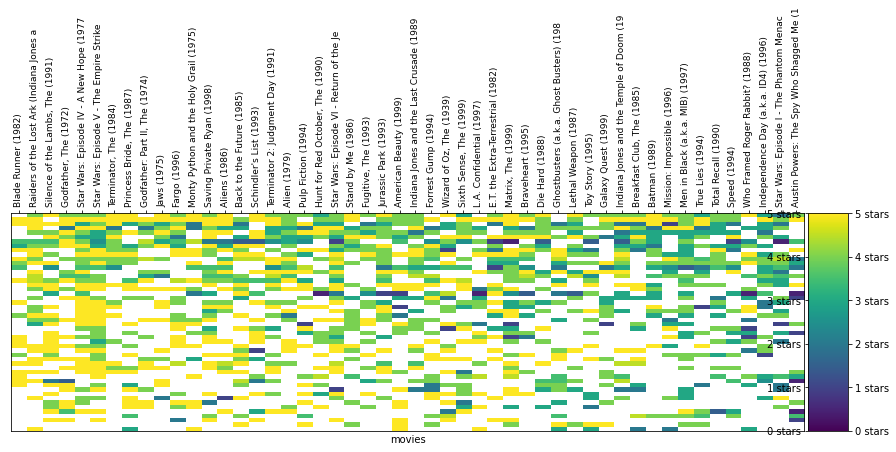

cluster # 3
# of users in cluster: 278. # of users in plot: 70


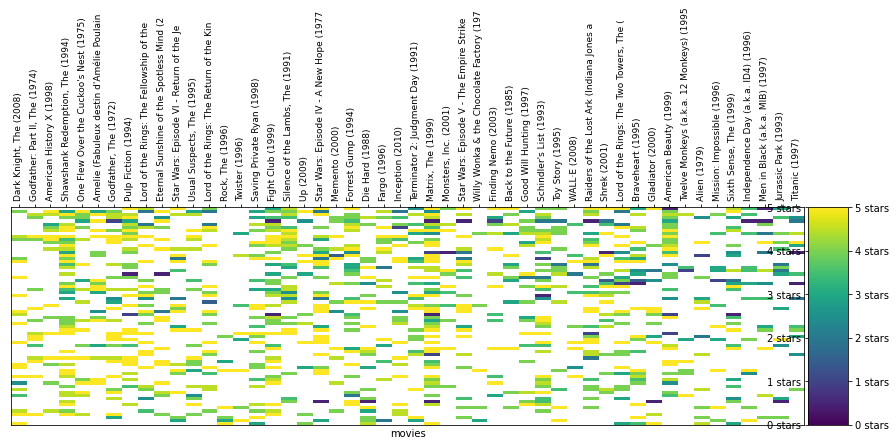

cluster # 6
# of users in cluster: 79. # of users in plot: 70


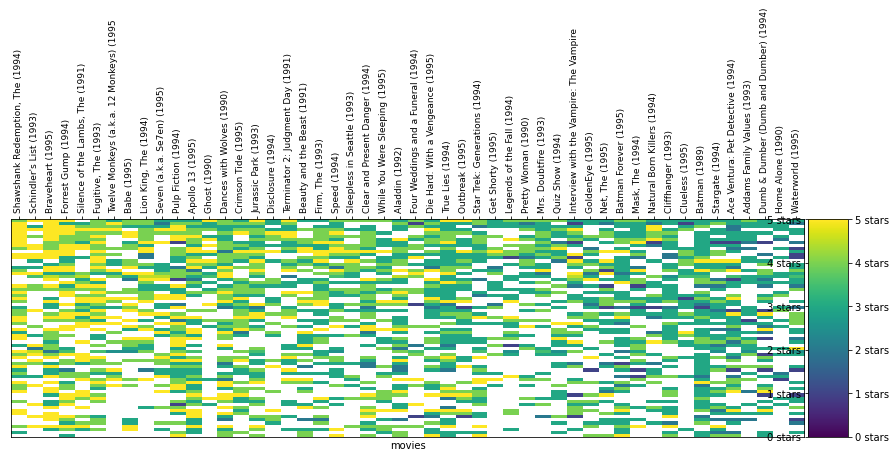

cluster # 0
# of users in cluster: 22. # of users in plot: 22


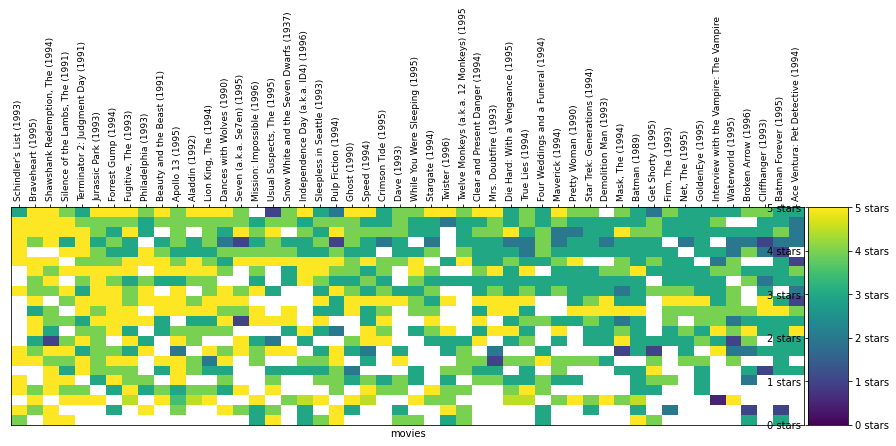

cluster # 7
# of users in cluster: 97. # of users in plot: 70


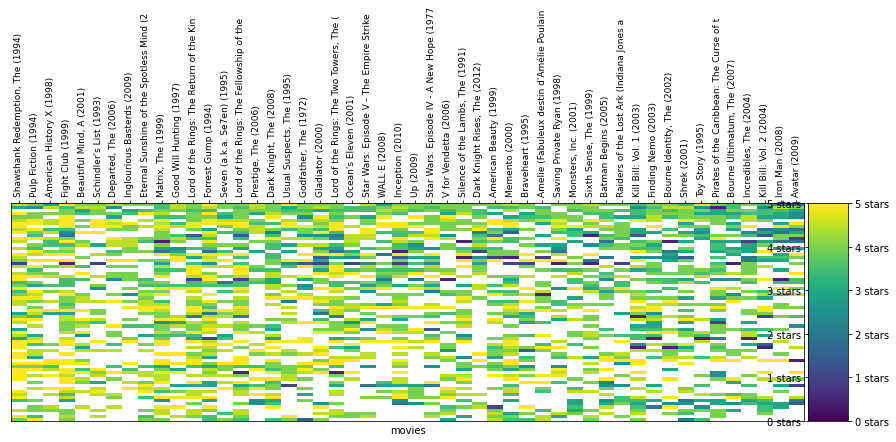

cluster # 8
# of users in cluster: 24. # of users in plot: 24


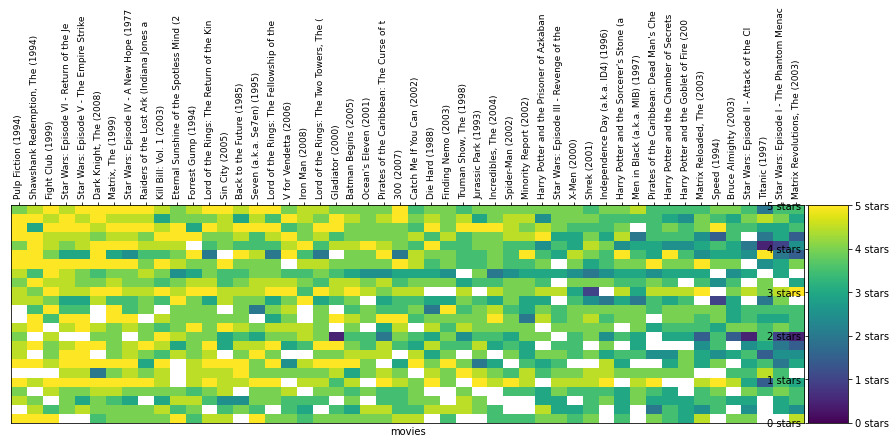

cluster # 9
# of users in cluster: 12. # of users in plot: 12


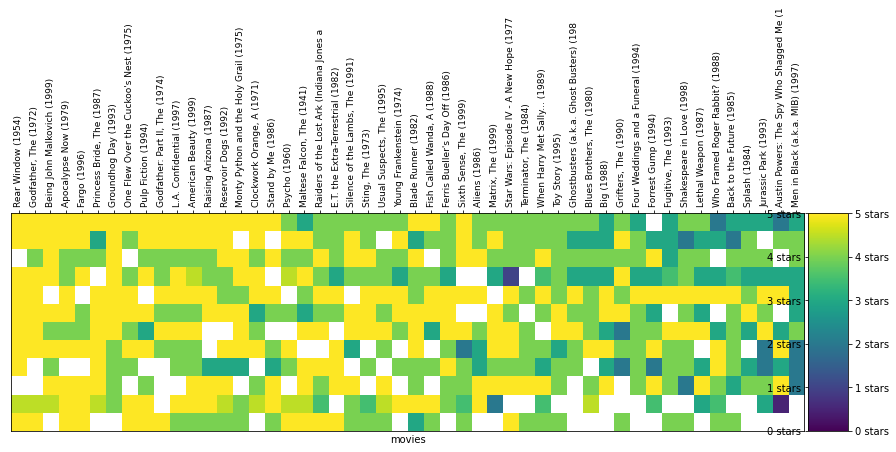

cluster # 4
# of users in cluster: 32. # of users in plot: 32


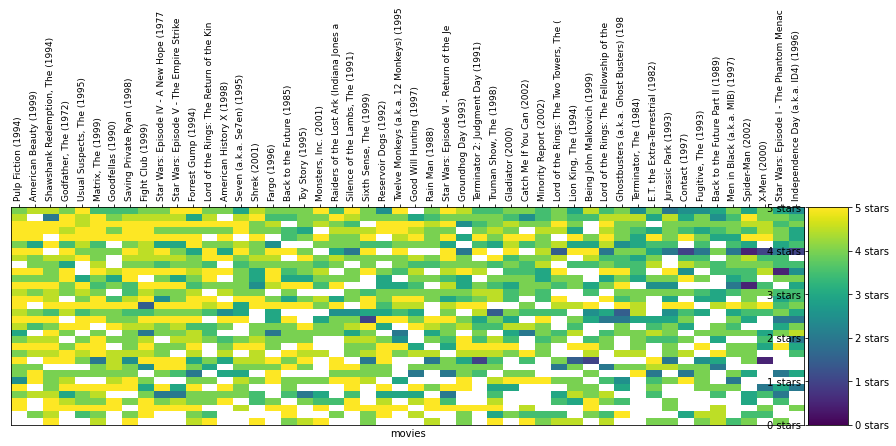

In [ ]:
max_users = 70
max_movies = 50
draw_movie_clusters(clustered, max_users, max_movies)

# Prediction

In [ ]:
clustered.head(1)

,index,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),American Beauty (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),"Lord of the Rings: The Two Towers, The (2002)",Saving Private Ryan (1998),"Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),...,Ghost in the Shell (Kôkaku kidôtai) (1995),"People vs. Larry Flynt, The (1996)",Bedazzled (2000),"Island of Dr. Moreau, The (1996)",Gosford Park (2001),"Princess Diaries, The (2001)",Rise of the Planet of the Apes (2011),Wayne's World 2 (1993),Evolution (2001),Star Trek Into Darkness (2013),All the President's Men (1976),Forever Young (1992),Pride & Prejudice (2005),Cube (1997),Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Arrival (2016),National Lampoon's Vacation (1983),Waking Ned Devine (a.k.a. Waking Ned) (1998),"Village, The (2004)","Virgin Suicides, The (1999)",Harold and Maude (1971),"Mighty Ducks, The (1992)",Dick Tracy (1990),Airheads (1994),¡Three Amigos! (1986),Roman Holiday (1953),Private Parts (1997),About Schmidt (2002),Jacob's Ladder (1990),"Transporter, The (2002)",The Hunger Games: Catching Fire (2013),21 Jump Street (2012),Moonraker (1979),In & Out (1997),Muppet Treasure Island (1996),Moneyball (2011),Rocky II (1979),"Big Short, The (2015)",Spawn (1997),group
0,0,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,NaN,5.0,NaN,5.0,NaN,5.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [ ]:
cluster_num = 3
num_users = 75
num_movies = 300

cluster = clustered[clustered.group == cluster_num].drop(['index','group'],axis=1)

# sort by rating density

most_rated_movies = get_most_rated_movies(cluster, max_movies)
cluster = get_users_who_rate_the_most(most_rated_movies, max_users)
cluster.index
# draw_movies_heatmap(cluster)

Int64Index([179, 225,  27, 230,  59,  23, 200, 148, 160, 156,  58, 246,  88,
             47, 187, 153, 113,  95,  64, 259,  31,  79,   9, 124,  11, 219,
             99, 218, 162,  38, 252, 223,  30, 198,   3, 132,  78,  77, 263,
             24, 186, 253, 155,   7, 222, 133,  89, 136, 237, 174,  42, 149,
            141, 196, 184, 111, 261, 128,  29,  26,  73, 195,  22,  25, 129,
            208, 235,  97,  10,  81],
           dtype='int64')

In [ ]:
cluster.fillna('').head()

,"Shawshank Redemption, The (1994)","Matrix, The (1999)",Forrest Gump (1994),Star Wars: Episode IV - A New Hope (1977),Fight Club (1999),Pulp Fiction (1994),American Beauty (1999),Schindler's List (1993),"Silence of the Lambs, The (1991)","Godfather, The (1972)",Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),Toy Story (1995),"Lord of the Rings: The Fellowship of the Ring, The (2001)","Lord of the Rings: The Two Towers, The (2002)",Saving Private Ryan (1998),Braveheart (1995),"Usual Suspects, The (1995)",Independence Day (a.k.a. ID4) (1996),Inception (2010),"Lord of the Rings: The Return of the King, The (2003)",Fargo (1996),Shrek (2001),Star Wars: Episode VI - Return of the Jedi (1983),Star Wars: Episode V - The Empire Strikes Back (1980),One Flew Over the Cuckoo's Nest (1975),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Sixth Sense, The (1999)",Terminator 2: Judgment Day (1991),"Dark Knight, The (2008)",Titanic (1997),Back to the Future (1985),American History X (1998),"Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)",Gladiator (2000),Eternal Sunshine of the Spotless Mind (2004),Jurassic Park (1993),Men in Black (a.k.a. MIB) (1997),Mission: Impossible (1996),Finding Nemo (2003),Memento (2000),Alien (1979),Die Hard (1988),Willy Wonka & the Chocolate Factory (1971),Good Will Hunting (1997),Up (2009),"Rock, The (1996)",Twister (1996),"Monsters, Inc. (2001)","Godfather: Part II, The (1974)",WALL·E (2008)
179,,5,5,5,3,5,0.5,4,4.5,,5,4,4.5,5,,3,,3.5,,4,,5,5,5,,,4.5,2.5,,,5,,,5,,3,0.5,,5,,,,,,,,,4,,
225,3,2.5,,2,4,,4,,4,4,4,,2,2,3,,3,,2,2,4.5,,,,5,,5,,4,,,5,3,,5,,,,,,,,,3,5,,,,,
27,5,5,4,5,,4.5,4.5,4.5,4.5,4.5,4.5,,,,,4.5,4.5,3.5,,,,,4.5,4.5,4,4.5,,4.5,,,4,4.5,5,,,,,4,,,,,,,,,,,4.5,
230,4,4.5,4,,3.5,5,4,4,3.5,4.5,,,,,3,,,,3.5,,4,,,,4,,3,,,2.5,,,,,2.5,3.5,,,3,4,2.5,4.5,,,,,,,4,
59,,0.5,3.5,,0.5,3,3,2,,1,0.5,2,,,,,,0.5,,,,2,,0.5,3,,,,,2,,,5,,5,,0.5,,1,4,,,,4,2.5,,,,,


In [ ]:
movie_name = "Matrix, The (1999)"
cluster[movie_name].mean()

4.0

In [ ]:

movie_name = "Silence of the Lambs, The (1991)"
cluster[movie_name].mean()

4.089285714285714

In [ ]:
movie_name = "Star Wars: Episode IV - A New Hope (1977)"
cluster[movie_name].mean()

4.080645161290323

In [ ]:

movie_name = "Star Wars: Episode VI - Return of the Jedi (1983)"
cluster[movie_name].mean()

4.157894736842105

# Recommendation

In [ ]:
cluster.mean().head(20)

Shawshank Redemption, The (1994)                                                  4.369048
Matrix, The (1999)                                                                4.000000
Forrest Gump (1994)                                                               4.066667
Star Wars: Episode IV - A New Hope (1977)                                         4.080645
Fight Club (1999)                                                                 4.094595
Pulp Fiction (1994)                                                               4.241935
American Beauty (1999)                                                            3.803030
Schindler's List (1993)                                                           3.944444
Silence of the Lambs, The (1991)                                                  4.089286
Godfather, The (1972)                                                             4.296296
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)    3.887097

In [ ]:

user_id = 24
print('USER {} ALREADY RATED THESE MOVIES - '.format(user_id))
print()
user_2_ratings  = cluster.loc[user_id, :]
user_2_ratings.dropna()

USER 24 ALREADY RATED THESE MOVIES - 



Shawshank Redemption, The (1994)                         5.0
Matrix, The (1999)                                       5.0
Forrest Gump (1994)                                      4.0
Star Wars: Episode IV - A New Hope (1977)                5.0
Pulp Fiction (1994)                                      5.0
Silence of the Lambs, The (1991)                         5.0
Usual Suspects, The (1995)                               5.0
Star Wars: Episode VI - Return of the Jedi (1983)        5.0
Star Wars: Episode V - The Empire Strikes Back (1980)    5.0
One Flew Over the Cuckoo's Nest (1975)                   5.0
Sixth Sense, The (1999)                                  5.0
Terminator 2: Judgment Day (1991)                        4.0
Titanic (1997)                                           4.0
Men in Black (a.k.a. MIB) (1997)                         4.0
Name: 24, dtype: float64

In [ ]:

# Get all this user's ratings
user_2_ratings  = cluster.loc[user_id, :]

# Which movies did they not rate? (We don't want to recommend movies they've already rated)
user_2_unrated_movies =  user_2_ratings[user_2_ratings.isnull()]

# What are the ratings of these movies the user did not rate?
avg_ratings = pd.concat([user_2_unrated_movies, cluster.mean()], axis=1, join='inner').loc[:,0]

# Let's sort by rating so the highest rated movies are presented first
print('RECOMMENDATIONS FOR USER = {} - '.format(user_id))
print()
avg_ratings.sort_values(ascending=False)[:20]

RECOMMENDATIONS FOR USER = 24 - 



Dark Knight, The (2008)                                      4.550000
Godfather: Part II, The (1974)                               4.533333
American History X (1998)                                    4.437500
Amelie (Fabuleux destin d'Amélie Poulain, Le) (2001)         4.315789
Godfather, The (1972)                                        4.296296
Lord of the Rings: The Fellowship of the Ring, The (2001)    4.200000
Eternal Sunshine of the Spotless Mind (2004)                 4.184211
Lord of the Rings: The Return of the King, The (2003)        4.152174
Rock, The (1996)                                             4.142857
Twister (1996)                                               4.125000
Saving Private Ryan (1998)                                   4.115385
Fight Club (1999)                                            4.094595
Up (2009)                                                    4.083333
Memento (2000)                                               4.076923
Die Hard (1988)     

In [ ]:
clustered.head(2)

,index,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),American Beauty (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),"Lord of the Rings: The Two Towers, The (2002)",Saving Private Ryan (1998),"Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),...,Ghost in the Shell (Kôkaku kidôtai) (1995),"People vs. Larry Flynt, The (1996)",Bedazzled (2000),"Island of Dr. Moreau, The (1996)",Gosford Park (2001),"Princess Diaries, The (2001)",Rise of the Planet of the Apes (2011),Wayne's World 2 (1993),Evolution (2001),Star Trek Into Darkness (2013),All the President's Men (1976),Forever Young (1992),Pride & Prejudice (2005),Cube (1997),Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Arrival (2016),National Lampoon's Vacation (1983),Waking Ned Devine (a.k.a. Waking Ned) (1998),"Village, The (2004)","Virgin Suicides, The (1999)",Harold and Maude (1971),"Mighty Ducks, The (1992)",Dick Tracy (1990),Airheads (1994),¡Three Amigos! (1986),Roman Holiday (1953),Private Parts (1997),About Schmidt (2002),Jacob's Ladder (1990),"Transporter, The (2002)",The Hunger Games: Catching Fire (2013),21 Jump Street (2012),Moonraker (1979),In & Out (1997),Muppet Treasure Island (1996),Moneyball (2011),Rocky II (1979),"Big Short, The (2015)",Spawn (1997),group
0,0,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,NaN,5.0,NaN,5.0,NaN,5.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2
1,1,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3


In [ ]:
prediction_series = avg_ratings.sort_values(ascending=False)[:20]

In [ ]:
df_prediction = df_movies[df_movies['title'].isin(list(avg_ratings.sort_values(ascending=False)[:10].index))]
df_prediciton = df_prediction.set_index('title')
df_prediciton['score'] = prediction_series
df_prediciton.sort_values(by='score',ascending=False).reset_index().set_index('movieId')

,title,genres,score
movieId,,,
58559,"Dark Knight, The (2008)",Action|Crime|Drama|IMAX,4.550000
1221,"Godfather: Part II, The (1974)",Crime|Drama,4.533333
2329,American History X (1998),Crime|Drama,4.437500
4973,"Amelie (Fabuleux destin d'Amélie Poulain, Le) ...",Comedy|Romance,4.315789
858,"Godfather, The (1972)",Crime|Drama,4.296296
4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy,4.200000
7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,4.184211
7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy,4.152174
733,"Rock, The (1996)",Action|Adventure|Thriller,4.142857


# Evaluation

In [ ]:
k = 10
rmse_list = []
mape_list = []
for i in range(0,k):
  num_users = 75
  num_movies = 300

  cluster = clustered[clustered.group == i].drop(['index','group'],axis=1)

  # sort by rating density

  most_rated_movies = get_most_rated_movies(cluster, max_movies)
  cluster = get_users_who_rate_the_most(most_rated_movies, max_users)
  # print(cluster.index)
  # print(cluster)
  # print(most_rated_movies)
  # print('Predicted scores -----')
  # print(cluster.mean().head(20))
  recommendation = cluster.mean().head(20)
  # print(recommendation)
  # for each user find the movies he rated


  # Get all this user's ratings
  for user_id in cluster.index:
    # print(user_id,'Movies he rated ---- ')
    user_2_ratings  = cluster.loc[user_id, :]
    user_2_ratings = user_2_ratings.dropna()
    # print(user_2_ratings)
    comb = pd.concat([recommendation, user_2_ratings], keys=['recommendation', 'rating'],axis=1)
    # print(comb.columns)
    comb = comb.dropna()
    rmse = ((comb['recommendation'] - comb['rating']) ** 2).mean() ** .5
    mape = np.mean(np.abs((comb['rating'] - comb['recommendation']) / comb['rating'])) * 100
    mape_list.append(mape)
    # print(rmse)
    rmse_list.append(rmse)

    


    
  # break


print('Avg RMSE',np.mean(rmse_list))
print('Avg MAPE',np.mean(mape_list))

# comb = comb.dropna()
# print(np.mean(np.abs((comb['rating'] - comb['recommendation']) / comb['rating'])) * 100)
# print(((comb[0] - comb[1]) ** 2).mean() ** .5)
# comb
# for index, row in df.iterrows():


Avg RMSE 0.8134992095683429
Avg MAPE 25.154572013297656


# Testing Other Clustering techniques

## Spectral Clustering - Skip

In [ ]:
from scipy.stats import multivariate_normal     # for generating pdf
from sklearn.cluster import SpectralClustering

In [ ]:
sc = SpectralClustering(n_clusters=10).fit_predict(sparse_ratings)

max_users = 70
max_movies = 50

clusteredsc = pd.concat([most_rated_movies.reset_index(), pd.DataFrame({'group':sc})], axis=1)
clusteredsc.head(5)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


,index,Forrest Gump (1994),"Shawshank Redemption, The (1994)",Pulp Fiction (1994),"Silence of the Lambs, The (1991)","Matrix, The (1999)",Star Wars: Episode IV - A New Hope (1977),Jurassic Park (1993),Braveheart (1995),Terminator 2: Judgment Day (1991),Schindler's List (1993),Fight Club (1999),Toy Story (1995),Star Wars: Episode V - The Empire Strikes Back (1980),American Beauty (1999),"Usual Suspects, The (1995)",Seven (a.k.a. Se7en) (1995),Independence Day (a.k.a. ID4) (1996),Apollo 13 (1995),Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981),"Lord of the Rings: The Fellowship of the Ring, The (2001)",Star Wars: Episode VI - Return of the Jedi (1983),"Godfather, The (1972)","Fugitive, The (1993)",Batman (1989),"Lord of the Rings: The Two Towers, The (2002)",Saving Private Ryan (1998),"Lord of the Rings: The Return of the King, The (2003)",Aladdin (1992),Fargo (1996),"Sixth Sense, The (1999)",True Lies (1994),Twelve Monkeys (a.k.a. 12 Monkeys) (1995),"Lion King, The (1994)",Back to the Future (1985),Speed (1994),Shrek (2001),Gladiator (2000),Men in Black (a.k.a. MIB) (1997),Dances with Wolves (1990),...,Ghost in the Shell (Kôkaku kidôtai) (1995),"People vs. Larry Flynt, The (1996)",Bedazzled (2000),"Island of Dr. Moreau, The (1996)",Gosford Park (2001),"Princess Diaries, The (2001)",Rise of the Planet of the Apes (2011),Wayne's World 2 (1993),Evolution (2001),Star Trek Into Darkness (2013),All the President's Men (1976),Forever Young (1992),Pride & Prejudice (2005),Cube (1997),Sunset Blvd. (a.k.a. Sunset Boulevard) (1950),Arrival (2016),National Lampoon's Vacation (1983),Waking Ned Devine (a.k.a. Waking Ned) (1998),"Village, The (2004)","Virgin Suicides, The (1999)",Harold and Maude (1971),"Mighty Ducks, The (1992)",Dick Tracy (1990),Airheads (1994),¡Three Amigos! (1986),Roman Holiday (1953),Private Parts (1997),About Schmidt (2002),Jacob's Ladder (1990),"Transporter, The (2002)",The Hunger Games: Catching Fire (2013),21 Jump Street (2012),Moonraker (1979),In & Out (1997),Muppet Treasure Island (1996),Moneyball (2011),Rocky II (1979),"Big Short, The (2015)",Spawn (1997),group
0,0,4.0,NaN,3.0,4.0,5.0,5.0,4.0,4.0,NaN,5.0,5.0,4.0,5.0,5.0,5.0,5.0,3.0,NaN,5.0,NaN,5.0,NaN,5.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN,NaN,NaN,5.0,NaN,NaN,5.0,3.0,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,1,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,3,NaN,NaN,1.0,5.0,1.0,5.0,NaN,NaN,NaN,NaN,2.0,NaN,5.0,5.0,NaN,2.0,NaN,NaN,3.0,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,4.0,5.0,4.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
4,4,NaN,3.0,5.0,NaN,NaN,NaN,NaN,4.0,3.0,5.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,4.0,3.0,NaN,NaN,NaN,4.0,3.0,NaN,2.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [ ]:
print(clusteredsc['group'].unique())
print(clusteredsc['group'].value_counts())
# clusteredsc.head()

[0 5 4 8 7 3 2 9 6 1]
0    600
8      2
9      1
7      1
6      1
5      1
4      1
3      1
2      1
1      1
Name: group, dtype: int64
